In [11]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.python.keras.layers import Dense
from numpy.random import default_rng
from sklearn.model_selection import train_test_split

In [31]:
# Loading pipeline params.
DATA_PATH = Path('data')
FILENAME_STOP = 'stop_90_diff_without_axis.csv'
FILENAME_0 = '0_90_diff_without_axis.csv'
FILENAME_90 = '90_90_diff_without_axis.csv'
FILENAME_180 = '180_90_diff_without_axis.csv'
FILENAME_270 = '270_90_diff_without_axis.csv'

NUM_TIMESTEPS = 6
IGNORE_FRACTION = 0.1
TEST_FRACTION = 0.25

# Training params.
LEARNING_RATE = 1e-5
EPOCHS = 100
BATCH_SIZE = 512

In [32]:
def load_data(
    path_stop,
    path_0,
    path_90,
    path_180,
    path_270,
    num_timesteps,
    ignore_fraction,
    test_fraction,
):

    def read_and_prepare_data(
        path,
        class_,
        num_timesteps,
        ignore_fraction,
        test_fraction,
    ):

        def split_temporally(X, test_fraction):
            num_samples = X.shape[0]
            num_train = int(num_samples * (1.0 - test_fraction))
            X_train, X_test = X[:num_train], X[num_train:]
            return X_train, X_test

        def transform_into_sequences(X, num_timesteps):
            num_samples = X.shape[0]
            X_seq = []
            for k in range(num_samples - num_timesteps + 1):
                X_seq.append(X[k:(k + num_timesteps)])
            X_seq = np.array(X_seq)
            y_seq = class_ * np.ones((X_seq.shape[0], 1))
            return X_seq, y_seq

        X = pd.read_csv(path).values
        X = X[:, [0,1,2,7,8,9]]  # Use only feet translations.

        # Ignore beginning and end.
        num_samples = X.shape[0]
        num_ignore = int(ignore_fraction * num_samples)
        X = X[num_ignore:-num_ignore]

        # Split X temporally.
        X_train, X_test = split_temporally(X, test_fraction)

        # Transform X into short sequences.
        X_train, y_train = transform_into_sequences(X_train, num_timesteps)
        X_test, y_test = transform_into_sequences(X_test, num_timesteps)

        return X_train, y_train, X_test, y_test

    def shuffle_data(X, y):
        idx = np.arange(len(X))
        default_rng().shuffle(idx)
        X_shuffled = X[idx, :]
        y_shuffled = y[idx]
        return X_shuffled, y_shuffled

    X_train_stop, y_train_stop, X_test_stop, y_test_stop = \
        read_and_prepare_data(
            path_stop,
            0.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )
    
    X_train_0, y_train_0, X_test_0, y_test_0 = \
        read_and_prepare_data(
            path_0,
            1.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )

    X_train_90, y_train_90, X_test_90, y_test_90 = \
        read_and_prepare_data(
            path_90,
            2.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )
    
    X_train_180, y_train_180, X_test_180, y_test_180 = \
        read_and_prepare_data(
            path_180,
            3.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )
    
    X_train_270, y_train_270, X_test_270, y_test_270 = \
        read_and_prepare_data(
            path_270,
            4.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )

    X_train = np.concatenate((X_train_stop, X_train_0, X_train_90, X_train_180, X_train_270), axis=0)
    y_train = np.concatenate((y_train_stop, y_train_0, y_train_90, y_train_180, y_train_270), axis=0)
    X_test = np.concatenate((X_test_stop, X_test_0, X_test_90, X_test_180, X_test_270), axis=0)
    y_test = np.concatenate((y_test_stop, y_test_0, y_test_90, y_test_180, y_test_270), axis=0)

    X_train, y_train = shuffle_data(X_train, y_train)
    X_test, y_test = shuffle_data(X_test, y_test)

    return X_train, X_test, y_train, y_test


path_stop = Path(DATA_PATH, FILENAME_STOP)
path_0 = Path(DATA_PATH, FILENAME_0)
path_90 = Path(DATA_PATH, FILENAME_90)
path_180 = Path(DATA_PATH, FILENAME_180)
path_270 = Path(DATA_PATH, FILENAME_270)

X_train, X_test, y_train, y_test = load_data(
    path_stop,
    path_0,
    path_90,
    path_180,
    path_270,
    NUM_TIMESTEPS,
    IGNORE_FRACTION,
    TEST_FRACTION,
)

In [33]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((100765, 6, 6), (100765, 1), (33573, 6, 6), (33573, 1))

In [51]:
X_test[60].shape


(6, 6)

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

CNN = Sequential(name="Sequential_CNN")

CNN.add(Conv2D(64, kernel_size=(4, 4),
               strides=(2, 2), padding="same",
               activation="selu", input_shape=[6, 6, 1]))

CNN.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1),
                     padding="valid"))

# Add another pair of Conv2D and MaxPooling2D for more model depth,
# followed by the flatten and multiple dense layers

CNN.add(Conv2D(32, kernel_size=(3, 3),
               strides=(1, 1), padding="same",
               activation="selu"))

CNN.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1),
                     padding="valid"))

CNN.add(Flatten())

CNN.add(Dense(64, activation='selu'))
CNN.add(Dense(32, activation='selu'))
CNN.add(Dense(5, activation='softmax'))

CNN.summary()


# from functools import partial

# _, num_time, num_feat = X_train.shape

# activation = 'selu'

# DefaultConv1D = partial(
#     keras.layers.Conv1D,
#     kernel_size=1,
#     activation=activation,
#     padding="valid",
# )

# model = keras.models.Sequential([
#     DefaultConv1D(4 * num_feat, kernel_size=4, input_shape=[num_time, num_feat]),
#     keras.layers.BatchNormalization(),
#     DefaultConv1D(num_feat, kernel_size=2),
#     keras.layers.Flatten(),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(num_time * num_feat, activation=activation),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(num_feat, activation=activation),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(5, activation='softmax'),
# ])

Model: "Sequential_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 3, 3, 64)          1088      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 2, 2, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 2, 2, 32)          18464     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 1, 1, 32)         0         
 g2D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 32)                0         
                                                                 
 dense_39 (Dense)            (None, 64)             

In [77]:
from numpy import *
where_are_NaNsx = isnan(X_train)
X_train[where_are_NaNsx] = 0

where_are_NaNsy = isnan(y_train)
y_train[where_are_NaNsy] = 0

where_are_NaNsxt = isnan(X_test)
X_test[where_are_NaNsxt] = 0

where_are_NaNsyt = isnan(y_test)
y_test[where_are_NaNsyt] = 0

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1e-2)

CNN.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)
history = CNN.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=256,
    validation_data=(X_test, y_test),
    verbose=1,
)

Epoch 1/100
394/394 [==============================] - 4s 9ms/step - loss: 0.7276 - accuracy: 0.6586 - val_loss: 0.3802 - val_accuracy: 0.8308
Epoch 2/100
394/394 [==============================] - 3s 8ms/step - loss: 0.4593 - accuracy: 0.7964 - val_loss: 0.3746 - val_accuracy: 0.8356
Epoch 3/100
394/394 [==============================] - 3s 8ms/step - loss: 0.4199 - accuracy: 0.8137 - val_loss: 0.3365 - val_accuracy: 0.8485
Epoch 4/100
394/394 [==============================] - 3s 9ms/step - loss: 0.4042 - accuracy: 0.8194 - val_loss: 0.3296 - val_accuracy: 0.8466
Epoch 5/100
394/394 [==============================] - 3s 9ms/step - loss: 0.3872 - accuracy: 0.8262 - val_loss: 0.3190 - val_accuracy: 0.8585
Epoch 6/100
394/394 [==============================] - 3s 9ms/step - loss: 0.3756 - accuracy: 0.8312 - val_loss: 0.3425 - val_accuracy: 0.8475
Epoch 7/100
394/394 [==============================] - 3s 8ms/step - loss: 0.3673 - accuracy: 0.8336 - val_loss: 0.3465 - val_accuracy: 0.8412

Epoch 58/100
394/394 [==============================] - 3s 8ms/step - loss: 0.2967 - accuracy: 0.8598 - val_loss: 0.3669 - val_accuracy: 0.8559
Epoch 59/100
394/394 [==============================] - 3s 8ms/step - loss: 0.2940 - accuracy: 0.8610 - val_loss: 0.3573 - val_accuracy: 0.8587
Epoch 60/100
394/394 [==============================] - 3s 8ms/step - loss: 0.2919 - accuracy: 0.8617 - val_loss: 0.4004 - val_accuracy: 0.8584
Epoch 61/100
394/394 [==============================] - 3s 8ms/step - loss: 0.2945 - accuracy: 0.8596 - val_loss: 0.3595 - val_accuracy: 0.8616
Epoch 62/100
394/394 [==============================] - 3s 8ms/step - loss: 0.2945 - accuracy: 0.8604 - val_loss: 0.3634 - val_accuracy: 0.8591
Epoch 63/100
394/394 [==============================] - 3s 8ms/step - loss: 0.2916 - accuracy: 0.8612 - val_loss: 0.3544 - val_accuracy: 0.8596
Epoch 64/100
394/394 [==============================] - 3s 8ms/step - loss: 0.2878 - accuracy: 0.8616 - val_loss: 0.3697 - val_accuracy:

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

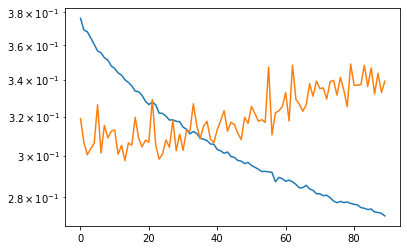

In [62]:
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])
plt.yscale('log')

In [63]:
y_pred = model.predict(X_test)

1050/1050 [==============================] - 5s 4ms/step


In [64]:
y_pred

array([[0.20014575, 0.19891343, 0.20021655, 0.20066689, 0.2000574 ],
       [0.19855939, 0.19442621, 0.203713  , 0.20022067, 0.20308076],
       [0.19753385, 0.19349755, 0.20359828, 0.20045093, 0.20491935],
       ...,
       [0.19948481, 0.20517828, 0.19513331, 0.19898993, 0.20121372],
       [0.1999451 , 0.20002945, 0.20001382, 0.19993176, 0.20007986],
       [0.20226058, 0.2019339 , 0.19728436, 0.20022811, 0.19829307]],
      dtype=float32)

In [65]:
y_pred= np.argmax(y_pred, axis=1)

In [66]:
y_pred

array([3, 2, 4, ..., 1, 4, 0])

In [67]:
y_pred[0]

3

In [68]:
df = pd.DataFrame({
    'y_test': y_test.ravel().astype(int).tolist(),
    'y_pred': y_pred.ravel().astype(int).tolist(),
})

In [69]:
pd.crosstab(df['y_test'], df['y_pred'])

y_pred,0,1,2,3,4
y_test,,,,,
0,3395,3795,1409,3841,1953
1,363,1604,476,1283,1069
2,430,1314,419,1710,922
3,490,1297,287,1569,1152
4,697,1066,619,1538,875


In [70]:
model.save('model.h5')

In [71]:
X_train[0]

array([[-0.   ,  0.   ,  0.   , -0.018,  0.001,  0.002],
       [-0.001,  0.   ,  0.   , -0.018,  0.   ,  0.001],
       [-0.   ,  0.   ,  0.   ,  0.003,  0.002, -0.003],
       [-0.   ,  0.   ,  0.   ,  0.013, -0.003, -0.002],
       [-0.   ,  0.   ,  0.   ,  0.014, -0.002, -0.006],
       [-0.   ,  0.   ,  0.001, -0.   ,  0.   ,  0.   ]])

In [ ]:
np.argmax(model.predict(np.array([[[0.08,  0.08,  0.08,  0.08, -0.08, -0.08, -0.08,  0.08],
       [0.08,  0.08,  0.08,  0.08, -0.08, -0.08, -0.08,  0.08],
       [0.08,  0.08,  0.08,  0.08, -0.08, -0.08, -0.08,  0.08],
       [0.08,  0.08,  0.08,  0.08, -0.08, -0.08, -0.08,  0.08],
       [0.08,  0.08,  0.08,  0.08, -0.08, -0.08, -0.08,  0.08],
       [0.08,  0.08,  0.08,  0.08, -0.08, -0.08, -0.08,  0.08],
       [0.08,  0.08,  0.08,  0.08, -0.08, -0.08, -0.08,  0.08],
       [0.08,  0.08,  0.08,  0.08, -0.08, -0.08, -0.08,  0.08],
       [0.08,  0.08,  0.08,  0.08, -0.08, -0.08, -0.08,  0.08],
       [0.08,  0.08,  0.08,  0.08, -0.08, -0.08, -0.08,  0.08]]])))

ValueError: ignored

In [ ]:
x_new = X_test[0,:,:]

In [ ]:
argmax(model.predict(np.array([[[-0.04,  0.69,  0.72,  0.07, -0.19, -0.63, -0.71,  0.23],
       [-0.13,  0.69,  0.7 ,  0.14, -0.19, -0.64, -0.71,  0.23],
       [-0.22,  0.67,  0.67,  0.23, -0.19, -0.64, -0.71,  0.23],
       [-0.25,  0.67,  0.65,  0.25, -0.19, -0.64, -0.71,  0.23],
       [-0.31,  0.65,  0.63,  0.3 , -0.19, -0.64, -0.71,  0.23],
       [-0.35,  0.63,  0.6 ,  0.34, -0.19, -0.64, -0.71,  0.23],
       [-0.34,  0.64,  0.61,  0.33, -0.19, -0.64, -0.71,  0.23],
       [-0.34,  0.64,  0.61,  0.33, -0.19, -0.64, -0.71,  0.23],
       [-0.24,  0.67,  0.66,  0.25, -0.19, -0.64, -0.71,  0.23],
       [-0.12,  0.69,  0.7 ,  0.14, -0.19, -0.64, -0.71,  0.23]]])))

In [ ]:
x_new.shape

In [ ]:
(1,) + x_new.shape

In [ ]:
X_new = x_new.reshape((1,) + x_new.shape)
fast_or_slow = saved_model(X_new)

In [ ]:
float(fast_or_slow[0, 0])

In [ ]:
print(X_new.tolist())


In [72]:
CNN.save('model_90_87.h5')

In [ ]:
np.fromstring(X_new.tobytes(), dtype=float).reshape(1,10,4)

In [ ]:
comma_string = "[[[-1.402271e-03 -2.203955e-08 7.028995e-07 9.999990e-01 -2.328306e-10 -6.455648e-09 7.037297e-07  1.000000e+00] [-1.402271e-03 -2.203955e-08  7.028995e-07  9.999990e-01 -2.328306e-10 -6.455648e-09  7.037297e-07  1.000000e+00] [-1.402271e-03 -2.203955e-08  7.028995e-07  9.999990e-01 -2.328306e-10 -6.455648e-09  7.037297e-07  1.000000e+00] [-1.402271e-03 -2.203955e-08  7.028995e-07  9.999990e-01 -2.328306e-10 -6.455648e-09  7.037297e-07  1.000000e+00] [-1.402271e-03 -2.203955e-08  7.028995e-07  9.999990e-01 -2.328306e-10 -6.455648e-09  7.037297e-07  1.000000e+00] [-1.402271e-03 -2.203955e-08  7.028995e-07  9.999990e-01 -2.328306e-10 -6.455648e-09  7.037297e-07  1.000000e+00] [-1.402271e-03 -2.203955e-08  7.028995e-07  9.999990e-01 -2.328306e-10 -6.455648e-09  7.037297e-07  1.000000e+00] [-1.402271e-03 -2.203955e-08  7.028995e-07  9.999990e-01 -2.328306e-10 -6.455648e-09  7.037297e-07  1.000000e+00] [-1.402271e-03 -2.203955e-08  7.028995e-07  9.999990e-01 -2.328306e-10 -6.455648e-09  7.037297e-07  1.000000e+00] [-1.402271e-03 -2.203955e-08  7.028995e-07  9.999990e-01 -2.328306e-10 -6.455648e-09  7.037297e-07  1.000000e+00]]])"

In [ ]:
spaces_string = comma_string.replace(' ', ',')
spaces_string

In [ ]:
import ast
input = np.array([[[0.08, 0.14, 0.09, 0.18],
       [0.08, 0.14, 0.09, 0.22],
       [0.08, 0.14, 0.08, 0.17],
       [0.08, 0.14, 0.08, 0.1 ],
       [0.08, 0.14, 0.07, 0.08],
       [0.08, 0.14, 0.07, 0.08],
       [0.09, 0.2 , 0.07, 0.08],
       [0.1 , 0.32, 0.07, 0.07],
       [0.1 , 0.29, 0.07, 0.07],
       [0.09, 0.24, 0.07, 0.07]]])
    
lista_string="[0.08, 0.14, 0.09, 0.18]"
lista= ast.literal_eval(lista_string)
input = np.insert(input[0], 0,lista).reshape(1,11,4)
input = input[:,:-1,:]
input

In [ ]:
from tensorflow.keras.models import load_model


In [ ]:
/content/my_model

In [ ]:
!zip -r model.zip model/ 

In [ ]:
print(json_str)

In [ ]:
input = np.array([[[ 2.66, -1.94,  0.66, -0.07],
       [ 2.66, -1.94,  0.66, -0.07],
       [ 2.65, -2.1 ,  0.66, -0.07],
       [ 2.65, -2.2 ,  0.66, -0.07],
       [ 2.65, -2.22,  0.66, -0.07],
       [ 2.65, -2.22,  0.68,  0.01],
       [ 2.64, -2.22,  0.68,  0.18],
       [ 2.64, -2.22,  0.69,  0.26],
       [ 2.64, -2.22,  0.67,  0.16],
       [ 2.64, -2.22,  0.67,  0.03]]])

In [ ]:
import ast
lista_string="[ 2.66, -1.94,  0.66, -0.07]"
lista= ast.literal_eval(lista_string)
input = np.append(input[0],[lista],axis=0).reshape(1,11,4)
input = input[:,1:,:]

In [ ]:
input

In [ ]:
X_train[0]

In [ ]:
import re

s = "[[[-1.402271e-03 -2.203955e-08  7.028995e-07  9.999990e-01 -2.328306e-10 -6.455648e-09  7.037297e-07  1.000000e+00] [-1.402271e-03 -2.203955e-08  7.028995e-07  9.999990e-01 -2.328306e-10 -6.455648e-09  7.037297e-07  1.000000e+00] [-1.402271e-03 -2.203955e-08  7.028995e-07  9.999990e-01 -2.328306e-10 -6.455648e-09  7.037297e-07  1.000000e+00] [-1.402271e-03 -2.203955e-08  7.028995e-07  9.999990e-01 -2.328306e-10 -6.455648e-09  7.037297e-07  1.000000e+00] [-1.402271e-03 -2.203955e-08  7.028995e-07  9.999990e-01 -2.328306e-10 -6.455648e-09  7.037297e-07  1.000000e+00] [-1.402271e-03 -2.203955e-08  7.028995e-07  9.999990e-01 -2.328306e-10 -6.455648e-09  7.037297e-07  1.000000e+00] [-1.402271e-03 -2.203955e-08  7.028995e-07  9.999990e-01 -2.328306e-10 -6.455648e-09  7.037297e-07  1.000000e+00] [-1.402271e-03 -2.203955e-08  7.028995e-07  9.999990e-01 -2.328306e-10 -6.455648e-09  7.037297e-07  1.000000e+00] [-1.402271e-03 -2.203955e-08  7.028995e-07  9.999990e-01 -2.328306e-10 -6.455648e-09  7.037297e-07  1.000000e+00] [-1.402271e-03 -2.203955e-08  7.028995e-07  9.999990e-01 -2.328306e-10 -6.455648e-09  7.037297e-07  1.000000e+00]]]"

def add_comma(match):
    return match.group(0) + ','

s = re.sub(r'\[[0-9\.\s]+\]', add_comma, s)
s = re.sub(r'([0-9\.]+)', add_comma, s)
mylist = eval(s)

In [ ]:
mylist